# Data preprocessing

We will not do extensive data manipulation. All we do here is we move images to appropriate folders. We then load them, resize them to (200, 200), and subtract the mean of each channel.

In [1]:
# moving images into cats and dogs subfolders
import os, glob, shutil

files = glob.glob('train/*')
fnames = [f.split('/')[1] for f in files]

os.makedirs('train/cats')
os.makedirs('train/dogs')

for fname in fnames:
    dogs_or_cats = 'dogs' if 'dog' in fname else 'cats'
    shutil.move(f'train/{fname}', f'train/{dogs_or_cats}/{fname}')

In [2]:
import keras, keras.preprocessing.image
from keras.utils import to_categorical
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [3]:
# reading and resizing images
gen = keras.preprocessing.image.ImageDataGenerator()
data = gen.flow_from_directory('train', target_size=(200, 200), batch_size=100, shuffle=False)

data.reset()
images, classes = data.next()
img_ary = np.array(images.astype('int16'))
cls_ary = np.array(classes)

for _ in range(24900 // 100):
    images, classes = data.next()
    img_ary = np.vstack((img_ary, images.astype('int16')))
    cls_ary = np.vstack((cls_ary, classes))

Found 25000 images belonging to 2 classes.


In [4]:
# image preprocessing - subtracting channel means
channel_means = img_ary.mean(axis=(0,1,2)).astype('int16')
img_ary = img_ary - channel_means

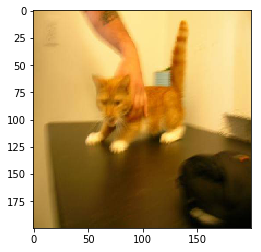

In [5]:
# just to convince ourselves everything worked ok
plt.imshow((img_ary[0] + channel_means).astype('uint8'))

In [6]:
# splitting the data into train, val and test sets
np.random.seed(2017)

ids = np.arange(12500)
np.random.shuffle(ids)

train_X = np.vstack((img_ary[[ids[:325]]], img_ary[[ids[:325] + 12500]]))
train_y = to_categorical([0] * 325 + [1] * 325)

val_X = np.vstack((img_ary[[ids[325:625]]], img_ary[[ids[325:625] + 12500]]))
val_y = to_categorical([0] * 300 + [1] * 300)

test_X = np.vstack((img_ary[[ids[625:12500]]], img_ary[[ids[625:12500] + 12500]]))
test_y = to_categorical([0] * 11875 + [1] * 11875)

# collecting all unlabeled images to use for pseudo labeling
unlabeled_X = np.vstack((img_ary[[ids[325:12500]]], img_ary[[ids[325:12500] + 12500]]))
unlabeled_y = to_categorical([0] * 12175 + [1] * 12175)

# Constructing our first, simple model

In [7]:
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization
from keras.layers import Activation, GlobalMaxPool2D, Dropout
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import Adam
import numpy as np

In [8]:
inputs = Input((200, 200, 3))

x = Conv2D(20, (2, 2), padding='same', kernel_regularizer=l2())(inputs)
x = BatchNormalization(axis=3)(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2), strides=(2,2))(x)

for _ in range(4):
    x = Conv2D(20, (2, 2), padding='same', kernel_regularizer=l2())(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2,2), strides=(2,2))(x)

x = Conv2D(30, (6, 6), padding='same')(x)
x = BatchNormalization(axis=3)(x)
x = Activation('relu')(x)
x = GlobalMaxPool2D()(x)
x = Dense(2, activation='softmax')(x)

model = Model(inputs, x)

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 20)      260       
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 200, 20)      80        
_________________________________________________________________
activation_1 (Activation)    (None, 200, 200, 20)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 20)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 20)      1620      
_________________________________________________________________
batch_normalization_2 (Batch (None, 100, 100, 20)      80        
__________

## Training

In [10]:
gen = keras.preprocessing.image.ImageDataGenerator()
data = gen.flow(train_X, train_y)

I run the following two cells an arbitrarily number of times untill I believe the model is fully trained. There is no good rule of a thumb here.

In general, I use values between 1e-4 and 1e-6 as the learning rate.

In [11]:
model.compile(Adam(lr=1e-6), 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit_generator(
    data,
    steps_per_epoch=12,
    epochs=6,
    validation_data=(val_X, val_y)
)

In [ ]:
# model.save_weights('first_model.weights')

After picking the final architecture, I trained the model and to not have to train the model over and over again when I come back to working on this, I save the weights.

I check the weights into the repo and load them below.

In [13]:
model.load_weights('first_model.weights')

In [14]:
# Test set performance
predictions = model.predict(test_X, 256)
np.mean(np.argmax(predictions, axis=1) == np.argmax(test_y, axis=1))

0.74378947368421056

# Training a model with data augmentation

I tried using the original model here, but it turned out to lack capacity to learn from augmented data. I construct a new, considerably bigger model.

In [15]:
inputs = Input((200, 200, 3))

x = Conv2D(128, (2, 2), padding='same', kernel_regularizer=l2(0.06))(inputs)
x = BatchNormalization(axis=3)(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2), strides=(2,2))(x)

for _ in range(4):
    x = Conv2D(128, (2, 2), padding='same', kernel_regularizer=l2(0.06))(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2,2), strides=(2,2))(x)

x = Conv2D(160, (6, 6), padding='same', kernel_regularizer=l2())(x)
x = BatchNormalization(axis=3)(x)
x = Activation('relu')(x)
x = GlobalMaxPool2D()(x)

x = Dense(2, activation='softmax')(x)

model = Model(inputs, x)

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 200, 200, 128)     1664      
_________________________________________________________________
batch_normalization_7 (Batch (None, 200, 200, 128)     512       
_________________________________________________________________
activation_7 (Activation)    (None, 200, 200, 128)     0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 100, 100, 128)     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 100, 100, 128)     65664     
_________________________________________________________________
batch_normalization_8 (Batch (None, 100, 100, 128)     512       
__________

In [17]:
gen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 25,
    width_shift_range= 0.2,
    height_shift_range = 0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.1
)

data = gen.flow(train_X, train_y)

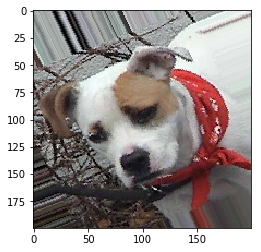

In [19]:
# We randomly transform each of the images we train on
plt.imshow((data.next()[0][0] + channel_means).astype('uint8'))

In [20]:
from keras.callbacks import Callback

# I decided to use a callback but probably more so to learn the keras API.
# Not sure this added a lot of value here but a variant of this could be useful
# when training much larger models over multiple hours / days.
class SaveWeightsCallback(Callback):
    def __init__(self):
        self.best_accuracy = 0
        
    def on_epoch_end(self, epoch, logs=None):
        if logs['val_acc'] > self.best_accuracy: 
            self.best_accuracy = logs['val_acc']
            model.save_weights('best_accuracy_callback.weights')

my_callback = SaveWeightsCallback()

In [21]:
model.compile(Adam(lr=1e-6), 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit_generator(
    data,
    steps_per_epoch=15,
    epochs=6,
    validation_data=(val_X, val_y),
    callbacks=[my_callback],
)

In [ ]:
# model.save_weights('second_model.weights')

In [23]:
# Weights saved and checked into repository, loading them here
model.load_weights('second_model.weights')

In [24]:
# Test set performance
predictions = model.predict(test_X, 128)
np.mean(np.argmax(predictions, axis=1) == np.argmax(test_y, axis=1))

0.83427368421052628

# Pseudo-labeling

We run the predictions, take the 1000 test examples where our model feels most strongly it is seeing a cat, and do exactly the same thing but for the dogs.

In [26]:
predictions_on_all_unlabeled_data = model.predict(unlabeled_X, 128)

In [27]:
# Constructing our third, biggest model

inputs = Input((200, 200, 3))

x = Conv2D(160, (2, 2), padding='same', kernel_regularizer=l2(0.06))(inputs)
x = BatchNormalization(axis=3)(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2), strides=(2,2))(x)

for _ in range(4):
    x = Conv2D(160, (2, 2), padding='same', kernel_regularizer=l2(0.06))(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2,2), strides=(2,2))(x)

x = Conv2D(200, (6, 6), padding='same', kernel_regularizer=l2())(x)
x = BatchNormalization(axis=3)(x)
x = Activation('relu')(x)
x = GlobalMaxPool2D()(x)

x = Dense(2, activation='softmax')(x)

model = Model(inputs, x)

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 200, 200, 160)     2080      
_________________________________________________________________
batch_normalization_13 (Batc (None, 200, 200, 160)     640       
_________________________________________________________________
activation_13 (Activation)   (None, 200, 200, 160)     0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 100, 100, 160)     0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 100, 100, 160)     102560    
_________________________________________________________________
batch_normalization_14 (Batc (None, 100, 100, 160)     640       
__________

In [29]:
pred_with_id = sorted(enumerate(predictions_on_all_unlabeled_data), key=lambda x: x[1][0], reverse=True)
strongest_cat_prediction_ids = [tup[0] for tup in pred_with_id[:1000]]
strongest_dog_prediction_ids = [tup[0] for tup in pred_with_id[-1000:]]

extra_cats = unlabeled_X[strongest_cat_prediction_ids, :]
extra_dogs = unlabeled_X[strongest_dog_prediction_ids, :]

In [30]:
model.compile(Adam(lr=1e-6), 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# One training epoch is one loop. Before each training epoch we pick 60 extra cat images
# and 60 extra dog images at random and add them to the train set. 

epoch_count = 5
for _ in range(epoch_count):
    gen = keras.preprocessing.image.ImageDataGenerator(
        rotation_range = 35,
        width_shift_range= 0.4,
        height_shift_range = 0.4,
        horizontal_flip=True,
        zoom_range=0.4,
        shear_range=0.3
    )

    np.random.shuffle(extra_dogs)
    np.random.shuffle(extra_cats)
    extended_train_X = np.vstack((train_X, extra_cats[:60], extra_dogs[:60]))
    extended_train_y = np.vstack((train_y, to_categorical(np.vstack((np.zeros((60,1)), np.ones((60,1)))))))

    data = gen.flow(extended_train_X, extended_train_y)

    model.fit_generator(
        data,
        steps_per_epoch=25,
        epochs=1,
        validation_data=(val_X, val_y),
        callbacks=[my_callback],
    )

In [ ]:
# model.save_weights('third_model.weights')

In [32]:
model.load_weights('third_model.weights')

In [33]:
# Test set performance
predictions = model.predict(test_X, 128)
np.mean(np.argmax(predictions, axis=1) == np.argmax(test_y, axis=1))

0.8514947368421053